In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
import keras_tuner as kt
import os
import random
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define hyperparameters
hyperparameters = {
    'learning_rate': 0.001,
    'batch_size': 8,
    'epochs': 50,
    'optimizer': 'adam',
    'loss_function': 'sparse_categorical_crossentropy',
    'image_size': (128, 128),
    'num_classes': 4,
    'data_augmentation': True,
}

# TensorBoard Logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the TensorBoard callback
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
)


In [3]:
# --- UPDATED PATHS ---
train_csv_path = "C:/Users/matko/Desktop/data_h_c_s_a/spectograms/train.csv"
train_img_dir = "C:/Users/matko/Desktop/data_h_c_s_a/spectograms/train"

# Load the dataset
train = pd.read_csv(train_csv_path)

# Split into train and validation sets
train, valid = train_test_split(
    train,
    test_size=0.2,         # 20% for validation
    stratify=train["category"],  # keep class distribution
    random_state=42
)

Train shape: (36128, 2)
Valid shape: (9032, 2)


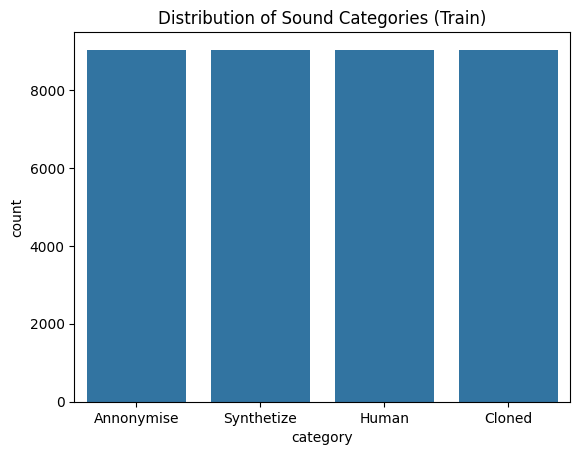

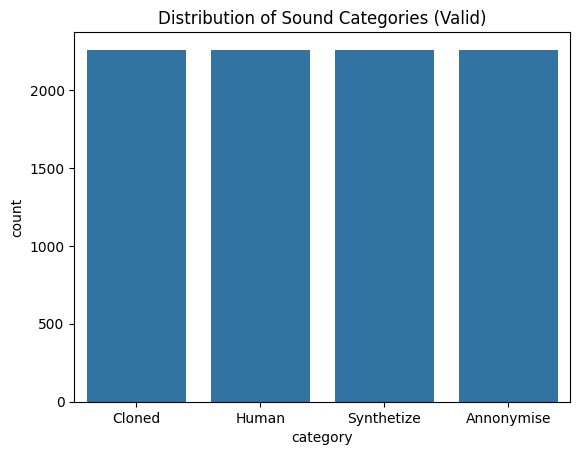

In [4]:
# Check the shape of the dataset
print("Train shape:", train.shape)
print("Valid shape:", valid.shape)

# Plot the distribution of ship categories
ship_categories = {0: 'Synthetize', 1: 'Annonymise', 2: 'Cloned', 3: 'Human'}
sns.countplot(x=train["category"].map(ship_categories))
plt.title("Distribution of Sound Categories (Train)")
plt.show()

sns.countplot(x=valid["category"].map(ship_categories))
plt.title("Distribution of Sound Categories (Valid)")
plt.show()

In [5]:
def load_and_preprocess_images(df, img_dir):
    images = []
    for img_name in df["image"]:  # Use the correct column name for image filenames
        img_path = os.path.join(img_dir, img_name)
        img = tf.keras.utils.load_img(img_path, color_mode='grayscale')  # No target_size needed
        imgarr = tf.keras.utils.img_to_array(img) / 255.0
        images.append(imgarr)
    return np.asarray(images)

# Prepare data
X_train = load_and_preprocess_images(train, train_img_dir)
X_valid = load_and_preprocess_images(valid, train_img_dir)



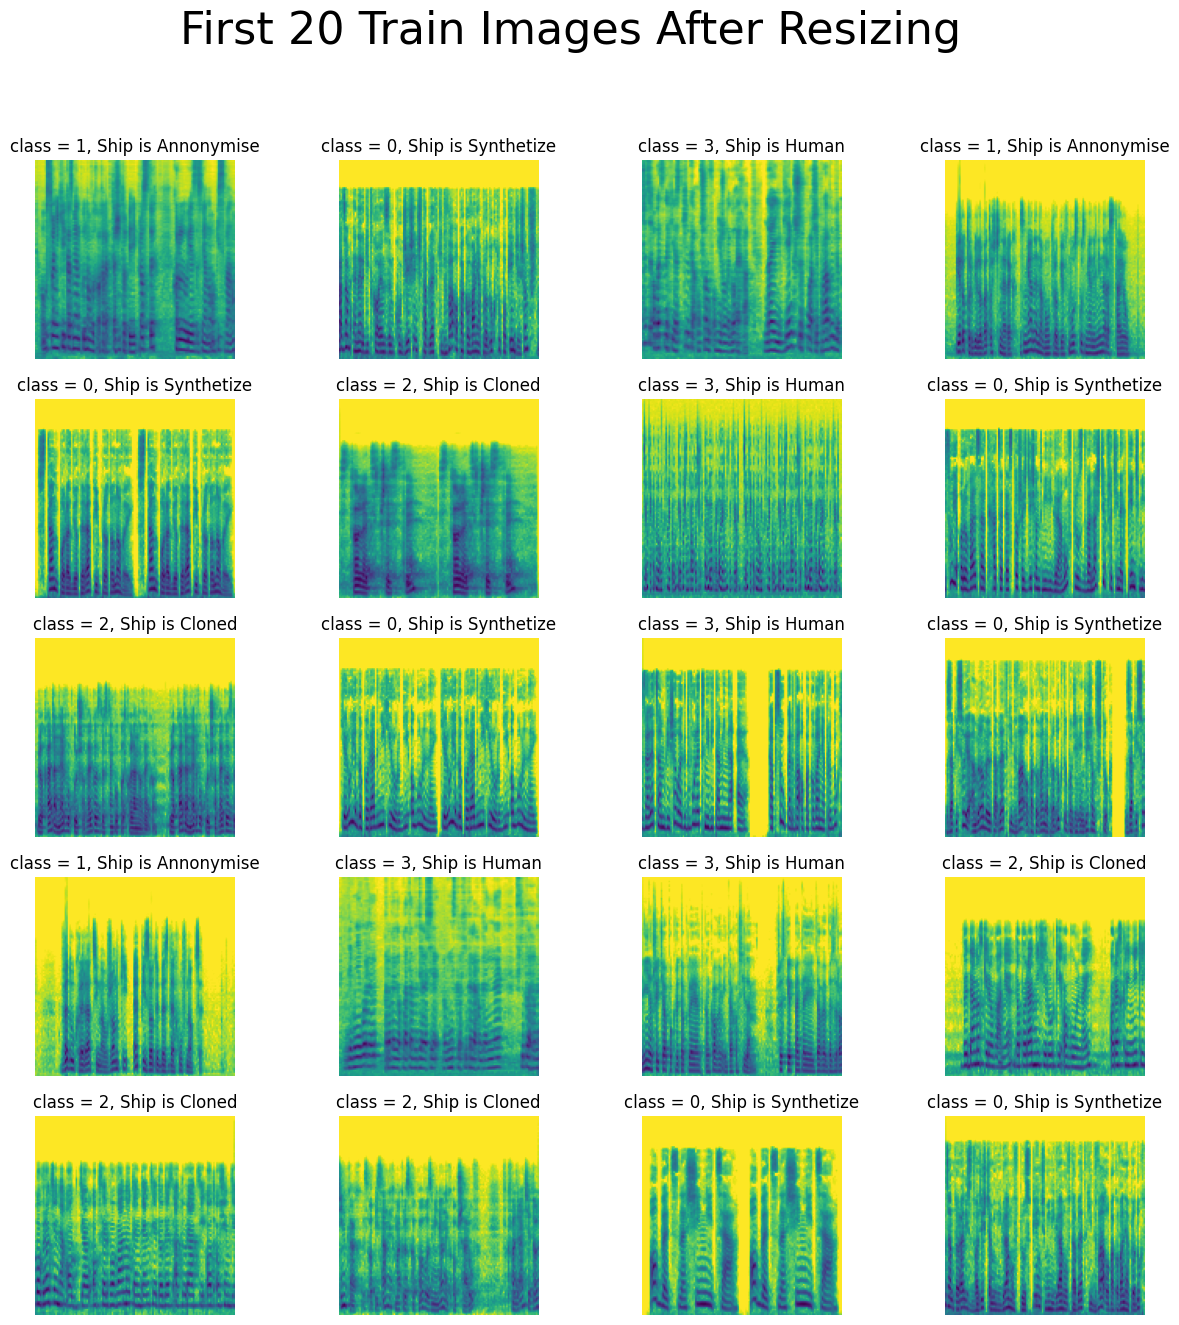

In [6]:
# Plot the first 20 resized images from train set
nrow = 5
ncol = 4
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('First 20 Train Images After Resizing', size=32)
for i in range(20):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(X_train[i])
    class_num = train["category"].iloc[i]  # <-- poprawka: iloc zamiast []
    plt.title(f'class = {class_num}, Ship is {ship_categories[class_num]}')
    plt.axis('off')
    plt.grid(False)
plt.show()


In [7]:
def create_model():
    inputs = layers.Input(shape=(128, 128, 1))
    
    # Initial block
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)
    
    # Conv1 block with attention gate
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    attention = layers.Conv2D(64, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])
    
    # Conv2 block with attention gate
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    attention = layers.Conv2D(128, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])
    
    # Conv3 block with attention gate
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    attention = layers.Conv2D(256, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])
    
    # Final layers
    x = layers.Conv2D(512, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(hyperparameters['num_classes'], activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

# Use the new model
model = create_model()
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss_function'],
    metrics=['accuracy']
)
model.summary()

# ModelCheckpoint Callback
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [8]:
def build_model(hp):
    # Use the same attention-based architecture as in create_model, but allow for hyperparameter tuning if needed
    inputs = Input(shape=(256, 256, 1))  # Use (256, 256, 1) to match your attention model

    # Initial block
    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Conv1 block with attention gate
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    attention = Conv2D(64, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])

    # Conv2 block with attention gate
    x = Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    attention = Conv2D(128, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])

    # Conv3 block with attention gate
    x = Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    attention = Conv2D(256, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])

    # Final layers
    x = Conv2D(512, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(hyperparameters['num_classes'], activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss=hyperparameters['loss_function'],
        metrics=['accuracy']
    )
    return model

In [9]:
# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='spectrogram_tuning'
)

Reloading Tuner from tuner_dir\spectrogram_tuning\tuner0.json


In [10]:
# Przygotuj y_train, y_valid jeśli jeszcze nie są przygotowane
y_train = train["category"]
y_valid = valid["category"]


In [ ]:
tuner.search(
    X_train, y_train,
    epochs=hyperparameters['epochs'],
    validation_data=(X_valid, y_valid),
    batch_size=hyperparameters['batch_size'],
    callbacks=[early_stopping, tensorboard_callback, checkpoint],
    verbose=1
)

In [10]:
# Reload the tuner from the directory
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='C:/Users/matko/Desktop/data_h_c_s_a/spectograms/tuner_dir',
    project_name='spectrogram_tuning'
)
tuner.reload()

# Get all trial IDs (as keys of the trials dict)
all_trial_ids = list(tuner.oracle.trials.keys())

# Get the last trial's ID and object
last_trial_id = all_trial_ids[-1]
last_trial = tuner.oracle.trials[last_trial_id]

# Extract hyperparameters from the last trial
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Najlepsze hiperparametry:", best_hps.values)


Reloading Tuner from C:/Users/matko/Desktop/data_h_c_s_a/spectograms/tuner_dir\spectrogram_tuning\tuner0.json
Najlepsze hiperparametry: {'filters': 16, 'num_blocks': 3, 'block_0_filters': 32, 'block_1_filters': 32, 'dense_units': 32, 'learning_rate': 0.00021893220837161223, 'block_2_filters': 16, 'block_3_filters': 16}


In [11]:
# Limit GPU memory growth to prevent allocation errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [11]:
# Create the model without tuner
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=hyperparameters['batch_size'],
    epochs=hyperparameters['epochs'],
    callbacks=[checkpoint, tensorboard_callback, early_stopping],
    verbose=1
)

Epoch 1/50
4516/4516 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8428
Epoch 1: val_accuracy improved from -inf to 0.87622, saving model to best_model.h5.keras
4516/4516 [==============================] - 136s 16ms/step - loss: 0.3204 - accuracy: 0.8428 - val_loss: 0.2234 - val_accuracy: 0.8762
Epoch 2/50
4511/4516 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.8749
Epoch 2: val_accuracy did not improve from 0.87622
4516/4516 [==============================] - 46s 10ms/step - loss: 0.2278 - accuracy: 0.8749 - val_loss: 0.5298 - val_accuracy: 0.8403
Epoch 3/50
4515/4516 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.8801
Epoch 3: val_accuracy did not improve from 0.87622
4516/4516 [==============================] - 44s 10ms/step - loss: 0.2054 - accuracy: 0.8801 - val_loss: 2.0270 - val_accuracy: 0.5499
Epoch 4/50
4515/4516 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.8829
Epoch 4: va

In [12]:
# Zbuduj i trenuj model z najlepszymi hiperparametrami
model_best = tuner.hypermodel.build(best_hps)
history_best = model_best.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=best_hps.values.get('batch_size', hyperparameters['batch_size']),
    epochs=hyperparameters['epochs'],
    callbacks=[checkpoint, tensorboard_callback, early_stopping],
)

Epoch 1/50
4514/4516 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.8131
Epoch 1: val_accuracy improved from -inf to 0.87356, saving model to best_model.h5.keras
4516/4516 [==============================] - 123s 25ms/step - loss: 0.4546 - accuracy: 0.8131 - val_loss: 0.2699 - val_accuracy: 0.8736
Epoch 2/50
4516/4516 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.8720
Epoch 2: val_accuracy did not improve from 0.87356
4516/4516 [==============================] - 113s 25ms/step - loss: 0.2533 - accuracy: 0.8720 - val_loss: 0.6287 - val_accuracy: 0.7034
Epoch 3/50
4514/4516 [============================>.] - ETA: 0s - loss: 0.2285 - accuracy: 0.8755
Epoch 3: val_accuracy improved from 0.87356 to 0.87998, saving model to best_model.h5.keras
4516/4516 [==============================] - 113s 25ms/step - loss: 0.2285 - accuracy: 0.8755 - val_loss: 0.2072 - val_accuracy: 0.8800
Epoch 4/50
4514/4516 [============================>.] - ETA: 0s - 

In [12]:
# Load the best model saved during training
best_model = models.load_model('best_model.h5.keras')

# Evaluate the best model on the validation set
val_loss, best_val_acc = best_model.evaluate(X_valid, y_valid, verbose=2)
print("\nBest Validation Accuracy:", best_val_acc)

# Predict classes for the validation set
val_predictions = best_model.predict(X_valid)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Calculate mean accuracy
mean_accuracy = accuracy_score(y_valid, val_predicted_classes)
print("Mean accuracy on the whole validation set:", mean_accuracy)

283/283 - 2s - loss: 0.1740 - accuracy: 0.8882 - 2s/epoch - 6ms/step

Best Validation Accuracy: 0.888175368309021
283/283 [==============================] - 1s 5ms/step
Mean accuracy on the whole validation set: 0.8881753764393269


283/283 [==============================] - 1s 4ms/step


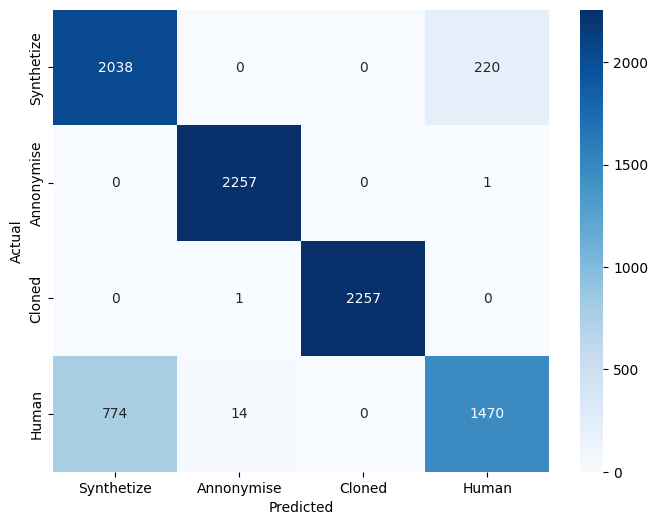

In [13]:
# Generate predictions
best_predictions = best_model.predict(X_valid)
best_predicted_classes = np.argmax(best_predictions, axis=1)

# Plot the confusion matrix
best_cm = confusion_matrix(y_valid, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=ship_categories.values(), yticklabels=ship_categories.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

43/43 [==============================] - 1s 12ms/step
Test accuracy: 0.9802


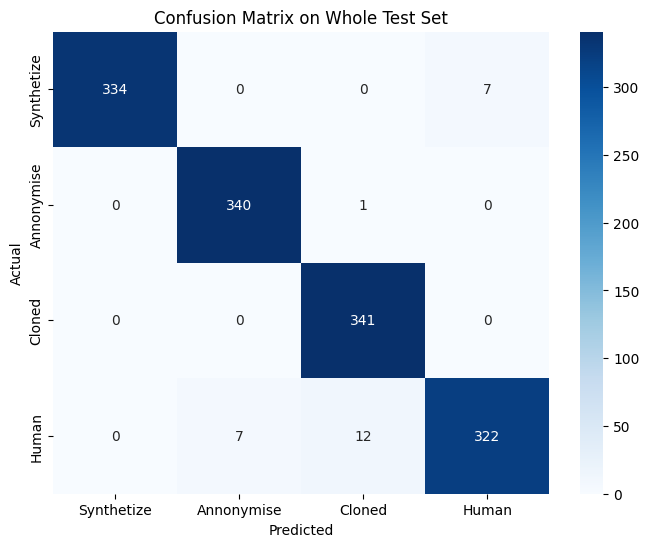

In [14]:
# Path to test images and labels
test_img_dir = "C:/Users/matko/Desktop/data_h_c_s_a/train_v3/test"
test_csv_path = "C:/Users/matko/Desktop/data_h_c_s_a/train_v3/test.csv"

# Load test image names and labels
test_img_names = os.listdir(test_img_dir)
test_df = pd.read_csv(test_csv_path)
test_df["Actual Class Index"] = test_df["category"] - 1  # zero-based

# Load and preprocess ALL test images
all_test_images = []
for img_name in test_img_names:
    img_path = os.path.join(test_img_dir, img_name)
    img = tf.keras.utils.load_img(img_path, target_size=hyperparameters['image_size'], color_mode='grayscale')
    imgarr = tf.keras.utils.img_to_array(img) / 255.0
    all_test_images.append(imgarr)
all_test_images = np.asarray(all_test_images)

# Predict classes for all test images
all_test_preds = best_model.predict(all_test_images)
all_test_pred_classes = np.argmax(all_test_preds, axis=1)

# Prepare actual class indices in the same order as test_img_names
actual_class_map = dict(zip(test_df["image"], test_df["Actual Class Index"]))
all_actual_class_indices = [actual_class_map[img] for img in test_img_names]

# Calculate test accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
test_accuracy = accuracy_score(all_actual_class_indices, all_test_pred_classes)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot confusion matrix for the whole test set
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_actual_class_indices, all_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=ship_categories.values(), 
            yticklabels=ship_categories.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Whole Test Set')
plt.show()